In [1]:
# Libraries
# ==============================================================================
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from skforecast.Sarimax import Sarimax
from skforecast.ForecasterSarimax import ForecasterSarimax
from skforecast.model_selection_sarimax import backtesting_sarimax
from skforecast.model_selection_sarimax import grid_search_sarimax
from skforecast.datasets import fetch_dataset
from pmdarima import ARIMA
from pmdarima import auto_arima
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_absolute_error
import warnings

warnings.filterwarnings("ignore")

c:\Users\Rawinan\.virtualenvs\geeks-db\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Download data
# ==============================================================================
data = fetch_dataset(name="h2o_exog")
data.index.name = "datetime"

h2o_exog
--------
Monthly expenditure ($AUD) on corticosteroid drugs that the Australian health
system had between 1991 and 2008. Two additional variables (exog_1, exog_2) are
simulated.
Hyndman R (2023). fpp3: Data for Forecasting: Principles and Practice (3rd
Edition). http://pkg.robjhyndman.com/fpp3package/,
https://github.com/robjhyndman/fpp3package, http://OTexts.com/fpp3.
Shape of the dataset: (195, 3)


Train dates : 1992-04-01 00:00:00 --- 2005-06-01 00:00:00  (n=159)
Test dates  : 2005-07-01 00:00:00 --- 2008-06-01 00:00:00  (n=36)


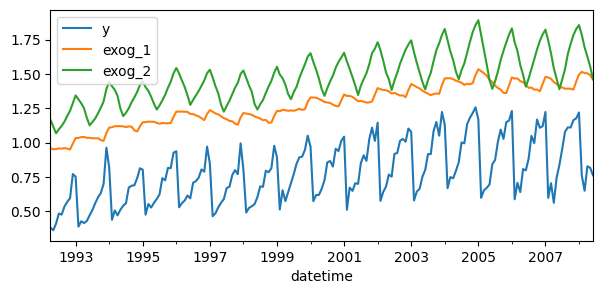

In [3]:
# Train-test dates
# ==============================================================================
end_train = "2005-06-01 23:59:59"
print(
    f"Train dates : {data.index.min()} --- {data.loc[:end_train].index.max()}  (n={len(data.loc[:end_train])})"
)
print(
    f"Test dates  : {data.loc[end_train:].index.min()} --- {data.loc[:].index.max()}  (n={len(data.loc[end_train:])})"
)
data_train = data.loc[:end_train]
data_test = data.loc[end_train:]

# Plot
# ==============================================================================
fig, ax = plt.subplots(figsize=(7, 3))
data.plot(ax=ax)
ax.legend()

Train dates      : 1992-04-01 00:00:00 --- 2001-01-01 00:00:00  (n=106)
Validation dates : 2001-02-01 00:00:00 --- 2006-01-01 00:00:00  (n=60)
Test dates       : 2006-02-01 00:00:00 --- 2008-06-01 00:00:00  (n=29)


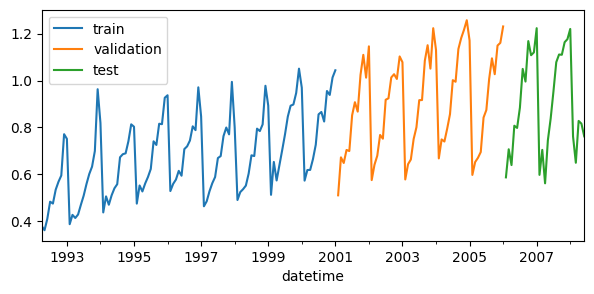

In [4]:
# Train-validation-test data
# ======================================================================================
end_train = "2001-01-01 23:59:00"
end_val = "2006-01-01 23:59:00"

print(
    f"Train dates      : {data.index.min()} --- {data.loc[:end_train].index.max()}  (n={len(data.loc[:end_train])})"
)
print(
    f"Validation dates : {data.loc[end_train:].index.min()} --- {data.loc[:end_val].index.max()}  (n={len(data.loc[end_train:end_val])})"
)
print(
    f"Test dates       : {data.loc[end_val:].index.min()} --- {data.index.max()}  (n={len(data.loc[end_val:])})"
)

# Plot
# ======================================================================================
fig, ax = plt.subplots(figsize=(7, 3))
data.loc[:end_train, "y"].plot(ax=ax, label="train")
data.loc[end_train:end_val, "y"].plot(ax=ax, label="validation")
data.loc[end_val:, "y"].plot(ax=ax, label="test")
ax.legend()

In [7]:
data.loc[:end_val, "y"]

datetime
1992-04-01    0.379808
1992-05-01    0.361801
1992-06-01    0.410534
1992-07-01    0.483389
1992-08-01    0.475463
                ...   
2005-09-01    1.094736
2005-10-01    1.027043
2005-11-01    1.149232
2005-12-01    1.160712
2006-01-01    1.230691
Freq: MS, Name: y, Length: 166, dtype: float64

In [10]:
data.index

DatetimeIndex(['1992-04-01', '1992-05-01', '1992-06-01', '1992-07-01',
               '1992-08-01', '1992-09-01', '1992-10-01', '1992-11-01',
               '1992-12-01', '1993-01-01',
               ...
               '2007-09-01', '2007-10-01', '2007-11-01', '2007-12-01',
               '2008-01-01', '2008-02-01', '2008-03-01', '2008-04-01',
               '2008-05-01', '2008-06-01'],
              dtype='datetime64[ns]', name='datetime', length=195, freq='MS')

In [8]:
# Grid search hyperparameter
# ======================================================================================
forecaster = ForecasterSarimax(
    regressor=Sarimax(order=(12, 1, 1), maxiter=200),
)

param_grid = {"order": [(12, 0, 0), (12, 1, 0), (12, 1, 1)], "trend": [None, "n", "c"]}

results_grid = grid_search_sarimax(
    forecaster=forecaster,
    y=data.loc[:end_val, "y"],
    param_grid=param_grid,
    steps=12,
    refit=False,
    metric="mean_absolute_error",
    initial_train_size=len(data_train),
    fixed_train_size=False,
    return_best=True,
    n_jobs="auto",
    suppress_warnings_fit=True,
    verbose=False,
    show_progress=True,
)

results_grid.head(5)

Number of models compared: 9.


params grid: 100%|██████████| 9/9 [00:25<00:00,  2.79s/it]


`Forecaster` refitted using the best-found parameters, and the whole data set: 
  Parameters: {'order': (12, 1, 1), 'trend': None}
  Backtesting metric: 0.06866797249591237



,params,mean_absolute_error,order,trend
6,"{'order': (12, 1, 1), 'trend': None}",0.068668,"(12, 1, 1)",None
7,"{'order': (12, 1, 1), 'trend': 'n'}",0.068668,"(12, 1, 1)",n
2,"{'order': (12, 0, 0), 'trend': 'c'}",0.076909,"(12, 0, 0)",c
0,"{'order': (12, 0, 0), 'trend': None}",0.077662,"(12, 0, 0)",None
1,"{'order': (12, 0, 0), 'trend': 'n'}",0.077662,"(12, 0, 0)",n
